<a href="https://colab.research.google.com/github/1722101709/Internship/blob/Mental-Causation/MentalCausation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***unzipping the image dataset***

In [ ]:
!unzip '/content/glioma.zip'

# ***Importing Modules***

In [ ]:
import numpy as np
import gym
from collections import deque
import random

## ***1.Adding Noise to the input to improve effeciency***
## ***2.Memory***

In [ ]:
class OUNoise(object): # noise class
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
        
    def reset(self): # resetting the state
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self): # exploring the next state
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0): # get action for the current state
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)


        
# memory class to store the experiences
class Memory:
    def __init__(self, max_size): # initializing memory with max_size
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)
    
    def push(self, state, action, reward, next_state, done): # push method to add experience into the memory
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size): # seperating the elements in the experience into  seperate lists
        state_batch = [] # states
        action_batch = [] # actions
        reward_batch = [] # rewards
        next_state_batch = [] # next state
        done_batch = [] # is_done

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)
        
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self): # to get the size of the memory filled with experiences
        return len(self.buffer)

## ***Actor Critic Network***

In [ ]:
# importing necessary modules
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.autograd
from torch.autograd import Variable

class Critic(nn.Module): # critic class to implement the critic network 
    
    def __init__(self, input_size, hidden_size, output_size): # initializing the critic network
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, state, action): # forward propogation i.e., input to the input layer => output from the output layer

        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        return x

class Actor(nn.Module): # Actor class to implement the Actor Network

    def __init__(self, input_size, hidden_size, output_size, learning_rate = 3e-4): # initializing the Actor network
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, state): # forward propogation in Actor network with input

        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))

        return x

# ***Agent***

In [ ]:
# importing necessary modules 
import torch
import torch.autograd
import torch.optim as optim
import torch.nn as nn


class DDPGagent: # agent class(Deep Deterministic Policy Gradient)

    # initilaizations
    def __init__(self, env, hidden_size=256, actor_learning_rate=1e-4, critic_learning_rate=1e-3, gamma=0.99, tau=1e-2, max_memory_size=50000):
        # Parameters
        self.num_states = env.observation_space.shape[0] # number of states
        self.num_actions = env.action_space.shape[0] # no of actions
        self.gamma = gamma
        self.tau = tau

        # Networks
        self.actor = Actor(self.num_states, hidden_size, self.num_actions) # actor network
        self.actor_target = Actor(self.num_states, hidden_size, self.num_actions) # actor target network
        self.critic = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions) # critic network
        self.critic_target = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions) # critic target network

        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        
        # Training
        self.memory = Memory(max_memory_size) # initialize the memory  
        self.critic_criterion  = nn.MSELoss() # loss function
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=actor_learning_rate) # optimizers for actor network
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_learning_rate) # optimizers for critic network
    
    def get_action(self, state): # to get the action for the state by passing state as input to the actor network
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        action = self.actor.forward(state)
        action = action.detach().numpy()[0,0]
        return action
    
    def update(self, batch_size): # updating the sampling after batch_size iterations
        states, actions, rewards, next_states, _ = self.memory.sample(batch_size)
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
    
        # Critic loss        
        Qvals = self.critic.forward(states, actions)
        next_actions = self.actor_target.forward(next_states)
        next_Q = self.critic_target.forward(next_states, next_actions.detach())
        Qprime = rewards + self.gamma * next_Q
        critic_loss = self.critic_criterion(Qvals, Qprime)

        # Actor loss
        policy_loss = -self.critic.forward(states, self.actor.forward(states)).mean()
        
        # update networks
        self.actor_optimizer.zero_grad() # actor network
        policy_loss.backward()
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad() # critic network
        critic_loss.backward() 
        self.critic_optimizer.step()

        # update target networks 
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))
       
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

## **KMeans**

In [ ]:
# importing necessary modules

import numpy as np
import pandas as pd
import random
from PIL import Image
import os
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# kmeans class 
class k_means():

    # forming initial clusters with the training data
    def __init__(self):
        self.x = self.get_data() # to get the training data
        self.count = 4
        self.data = self.preprocessing(self.x) # preprocessing the data
        self.x_principled = self.data[:][:self.count]
        self.no_of_clusters = self.silhouette(self.x_principled) # to get the optimised k value
        self.learning = [self.no_of_clusters] # to store clusters count
        self.kmeans = KMeans(n_clusters=self.no_of_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0 ) # kmeans object
        self.predicted = self.kmeans.fit_predict(self.x_principled) # applying kmeans on training data


    """# ***plotting scatter plot of clusters***"""

    def plot(self):

        plt.scatter(self.x_principled['F1'], np.ones(self.x_principled.shape[0]))
        plt.scatter(self.kmeans.cluster_centers_[:], np.ones(self.kmeans.cluster_centers_.shape[0]),s=100, c='orange')
        plt.title('Graph with clusters of action')
        plt.legend(['cluster points','cluster centers'], loc = "lower right" )
        plt.xlabel('Actions')
        plt.show()


    """# ***Plotting Learning***"""
    def plot_learning(self):

        plt.plot(self.learning) # plot the change in clusters count

    
    """# ***preprocessing***"""

    def preprocessing(self,x):

        x_scaler = StandardScaler().fit_transform(x) # Scaling

        x_normalize = pd.DataFrame(normalize(x_scaler)) # normalizing

        x_pca = pd.DataFrame(PCA(n_components=1).fit_transform(x_normalize)) # applying PCA and storing the result in dataframe


        x_pca.columns = ['F1'] # adjusting the column names

        return x_pca
    

    """# ***to find the optimal no of clusters for the given data***"""

    def silhouette(self,x):
        
        self.sil = [] # to store silhouette scores for different k values
        kmax = len(x)

        for k in range(2, kmax): # forming clusters with k = 2 to maximum no of data points
            kmeans = KMeans(n_clusters = k).fit(x)
            labels = kmeans.labels_
            self.sil.append(silhouette_score(x, labels, metric = 'euclidean')) # finding the silhouette score for clusters_count = k

        k = self.sil.index(max(self.sil))+2 # optimised k value

        self.kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0 )
        self.predicted = self.kmeans.fit_predict(self.x_principled) # forming clusters with optimized clusters

        return k


    """# *** to visualize the silhouette_scores of the data for different cluster counts***"""

    def silhouette_score(self):
        plt.plot(range(2,len(self.sil)+2), self.sil)
        plt.show()


    """# ***Prediction of new data point***"""

    def predict(self,input):

        # to find the cluster of new data point to go into
        self.x_principled.loc[len(self.x_principled.index)]  = input
        optimized_k = self.silhouette(self.x_principled)
        n_clusters = self.no_of_clusters
        self.no_of_clusters = optimized_k
        self.learning.append(self.no_of_clusters)

        b = self.x_principled['F1']
        c = self.kmeans.cluster_centers_
        x = b[len(b)-1]
        dif = 6
        cluster = 0
        for i in range(len(c)):
            t = abs(c[i]-x)
            if t<dif:
                dif = t
                cluster = i

        labels = self.kmeans.labels_

        # to find the data points that are in the same cluster as new data point
        sim_points_num = ['Action_'+str(i+1) for i in range(len(b)-1) if labels[i] == cluster]
        sim_points = [b[i] for i in range(len(b)-1) if labels[i] == cluster]
        # print('Do new or modified or improvised action of following actions:-', '-'*30, *sim_points_num, '-'*30, sep='\n',end='\n\n')

        # finding the reward based on the similarity
        no_of_sim_actions = len(sim_points)
        if  no_of_sim_actions == 0:
            return 0
        sim_per = self.sim(sim_points)
        if  -0.005<=sim_per <= 0.005 :
            return 1
        elif 0.005<sim_per<=0.05 or -0.05<sim_per<-0.005:
            return abs(sim_per)*5
        else:
            return 0

    """# *** reading training data ***"""

    def get_data(self): # converting the image dataset to vector form
        
        img = Image.open('/content/glioma/Te-gl__0001.jpg').convert('RGBA')
        arr = np.array(img)
        flat_arr = arr.ravel()
        columns = flat_arr.shape[0]
        vector = np.matrix(flat_arr)

        df = pd.DataFrame(vector)

        for i in range(2,300):
            path = '/content/glioma/Te-gl__'+'{0:04d}'.format(i)+'.jpg'
            if os.path.exists(path):
                img = Image.open(path).convert('RGBA')
                arr = np.array(img)
                flat_arr = arr.ravel()
                size = flat_arr.shape[0]
                if size >= columns:
                    df.loc[len(df)] = flat_arr[:columns]
                else:
                    for i in range(columns-size):
                        flat_arr.append(0)
                    df.loc[len(df)] = flat_arr
        return df

    # similarity between points

    def sim(self, l):
        s = 0
        l.sort()
        for i in range(1,len(l)):
            s += abs(l[i]-l[i-1])
        return round(s/len(l),7)
    
    # next input signal

    def get_next_signal(self):
        self.count += 1
        if self.count == len(self.data):
            return True, np.array(self.data.iloc[self.count-1])
        return False, np.array(self.data.iloc[self.count-1])


## ***Environment***

In [ ]:
# importing modules
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random

# Environment
class Environment(Env):

    def __init__(self): # initializing environment

        self.ai = k_means()
        self.action_space = Box(low = np.array([-1]), high = np.array([1]), dtype=float)
        self.observation_space = Box(low = np.array([-1]), high = np.array([1]), dtype=float)
        self.state = np.random.random(1)

    def step(self, action): # taking actions on environment

        reward = self.ai.predict(action)
        done, next_state = self.ai.get_next_signal()
        self.state = next_state
        return self.state,reward,done,{}

    def reset(self): # reset the environment
        self.__init__()
        return self.state


## ***Without Feedback Protocol***

episode: 1, reward: 7.37, average _reward: 7.371693000000001 

episode: 2, reward: 12.8, average _reward: 10.083464 

episode: 3, reward: 6.3, average _reward: 8.823254999999998 

episode: 4, reward: 6.24, average _reward: 8.178595374999999 

episode: 5, reward: 9.41, average _reward: 8.425670799999999 

episode: 6, reward: 11.32, average _reward: 8.908605249999999 

episode: 7, reward: 9.81, average _reward: 9.037944714285715 

episode: 8, reward: 8.02, average _reward: 8.9102580625 

episode: 9, reward: 7.37, average _reward: 8.738722555555556 

episode: 10, reward: 5.37, average _reward: 8.402293700000001 



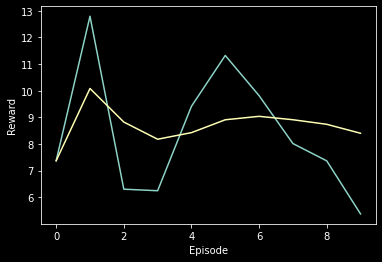

In [ ]:
# importing modules
import sys
import gym
import numpy as np
import pandas as pd
import random
rewards = [] # to store rewards of episode
avg_rewards = [] # to store average rewards of each episode
episodes = 10 # episodes
steps = 50 # no of steps in an episode
for episode in range(episodes):
    episode_reward = 0
    env = Environment()
    for step in range(steps):
        action = random.uniform(-1,1) # randomly taking actions as there is no feedback
        new_state, reward, done, _ = env.step(action) # applying action on the environment
        episode_reward += reward
    
    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))
    # print total reward for the episode and average_reward per episode
    print("episode: {}, reward: {}, average _reward: {} \n".format(episode+1, np.round(episode_reward, decimals=2), np.mean(rewards[-10:])))
without_feedback_rewards = rewards
without_feedback_avg_rewards = avg_rewards

# plotting rewards, average_rewards vs episode graph
from matplotlib import pyplot as plt
plt.plot(rewards)
plt.plot(avg_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

# ***With Feedback Protocol***

In [ ]:
#importing modules
import sys
import gym
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

env = Environment() # creating environment

agent = DDPGagent(env) # agent
noise = OUNoise(env.action_space) # noise class object
batch_size = 2 
rewards = []
avg_rewards = []
episodes = 10 # no of episodes
steps = 50 # no of steps in an episode
for episode in range(episodes):
    state = env.reset()
    noise.reset()
    episode_reward = 0
    for step in range(steps):
        action = agent.get_action(state) # get action from Agent
        action = noise.get_action(action, step) # add noise to the action
        new_state, reward, done, _ = env.step(action) # apply action on the environment
        agent.memory.push(state, action, reward, new_state, done) # store the experience in the memory
        
        if len(agent.memory) > batch_size: # update the sampling after batch_size iterations
            agent.update(batch_size)
        
        state = new_state
        episode_reward += reward
        if done: # if environment was explored fully then, stop
            break
 
    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))
    # print total reward for the episode and average_reward per episode
    print("episode: {}, reward: {}, average _reward: {} \n".format(episode+1, np.round(episode_reward, decimals=2), np.mean(rewards[-10:])))
with_feedback_rewards = rewards
with_feedback_avg_rewards = avg_rewards


episode: 1, reward: 17.37, average _reward: 17.3671025 

episode: 2, reward: 8.74, average _reward: 13.053532500000003 

episode: 3, reward: 15.39, average _reward: 13.831160833333335 

episode: 4, reward: 4.83, average _reward: 11.579700125 

episode: 5, reward: 17.61, average _reward: 12.784870100000001 

episode: 6, reward: 5.42, average _reward: 11.557575083333333 

episode: 7, reward: 6.6, average _reward: 10.848970928571429 

episode: 8, reward: 22.85, average _reward: 12.34899775 

episode: 9, reward: 10.98, average _reward: 12.196926277777779 

episode: 10, reward: 27.14, average _reward: 13.6907618 



## ***Plotting average_rewards_per_episode vs episodes without feedback vs with feedback protocol***

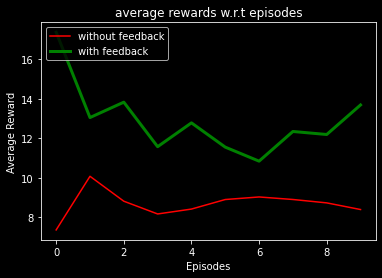

In [ ]:
from matplotlib import pyplot as plt
import matplotlib as mpl
plt.plot(without_feedback_avg_rewards,'r',linewidth=1.5)
plt.plot(with_feedback_avg_rewards,'g',linewidth=3)
plt.plot()
plt.legend(["without feedback", "with feedback"], loc ="upper left")
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('average rewards w.r.t episodes')
plt.style.use('dark_background')
plt.show()



---


## ***=====> Using normalized feedback protocol <=====***

---



In [ ]:
# importing modules
import numpy as np
import gym
from collections import deque
import random

# memory class to store the non-duplicates to achieve normalized feedback
class Memory_Normalized:
    def __init__(self, max_size): # initialization
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)
    
    def push(self, state, action, reward, next_state, done): # pushing experience of each step into the memory
        experience = (state, action, np.array([reward]), next_state, done)
        if experience not in self.buffer:
            self.buffer.append(experience)

    def sample(self, batch_size): # sampling the experience
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)
        
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self): # to know the size of memory filled
        return len(self.buffer)

### ***Agent***

In [ ]:
# importing modules
import torch
import torch.autograd
import torch.optim as optim
import torch.nn as nn

# agent class
class DDPGagent:
    def __init__(self, env, hidden_size=256, actor_learning_rate=1e-4, critic_learning_rate=1e-3, gamma=0.99, tau=1e-2, max_memory_size=50000):
        # Parameters
        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.shape[0]
        self.gamma = gamma
        self.tau = tau

        # Networks
        self.actor = Actor(self.num_states, hidden_size, self.num_actions)
        self.actor_target = Actor(self.num_states, hidden_size, self.num_actions)
        self.critic = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)
        self.critic_target = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)

        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        
        # Training
        self.memory = Memory_Normalized(max_memory_size)     
        self.critic_criterion  = nn.MSELoss() # loss criteria
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=actor_learning_rate) # optimizer for actor network
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_learning_rate) # optimizer for critic network
    
    def get_action(self, state): # get the action by forward propogation in actor network
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        action = self.actor.forward(state)
        action = action.detach().numpy()[0,0]
        return action
    
    def update(self, batch_size): # update the sampled data after batch size
        states, actions, rewards, next_states, _ = self.memory.sample(batch_size)
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
    
        # Critic loss        
        Qvals = self.critic.forward(states, actions)
        next_actions = self.actor_target.forward(next_states)
        next_Q = self.critic_target.forward(next_states, next_actions.detach())
        Qprime = rewards + self.gamma * next_Q
        critic_loss = self.critic_criterion(Qvals, Qprime)

        # Actor loss
        policy_loss = -self.critic.forward(states, self.actor.forward(states)).mean()
        
        # update networks
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()
        critic_loss.backward() 
        self.critic_optimizer.step()

        # update target networks 
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))
       
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

## **Agent taking actions on environment using Normalized feedback protocol**

In [ ]:
# importing modules
import sys
import gym
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

env = Environment() # creating environment

agent = DDPGagent(env) # agent
noise = OUNoise(env.action_space) # noise object
batch_size = 2 # batch size
rewards = [] # to store rewards of each episode
avg_rewards = [] # to store average reward per episode
episodes = 10 # no of episodes
steps = 50 # no of steps in an episode
for episode in range(episodes):
    state = env.reset()
    noise.reset()
    episode_reward = 0
    for step in range(steps):
        action = agent.get_action(state) # get the best action from the agent
        action = noise.get_action(action, step) # add noise to the action
        new_state, reward, done, _ = env.step(action) # apply action on the environment
        agent.memory.push(state, action, reward, new_state, done) # store the experience of the step in memory
        
        if len(agent.memory) > batch_size:
            agent.update(batch_size)
        
        state = new_state
        episode_reward += reward
        if done: # stop when agent completely explored the environment
            break
 
    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))
    # print total reward for the episode and average_reward per episode
    print("episode: {}, reward: {}, average _reward: {} \n".format(episode+1, np.round(episode_reward, decimals=2), np.mean(rewards[-10:])))
norm_feedback_rewards = rewards
norm_feedback_avg_rewards = avg_rewards


episode: 1, reward: 5.86, average _reward: 5.8630855 

episode: 2, reward: 5.61, average _reward: 5.736686 

episode: 3, reward: 23.59, average _reward: 11.686945166666666 

episode: 4, reward: 10.81, average _reward: 11.468103999999999 

episode: 5, reward: 25.41, average _reward: 14.2574722 

episode: 6, reward: 16.73, average _reward: 14.669595916666667 

episode: 7, reward: 38.02, average _reward: 18.00521242857143 

episode: 8, reward: 11.07, average _reward: 17.1385453125 

episode: 9, reward: 10.96, average _reward: 16.451730833333333 

episode: 10, reward: 29.53, average _reward: 17.759454799999997 



# *Plotting average_rewards_per_episode vs episodes without normalized feedback vs with normalized feedback protocol*

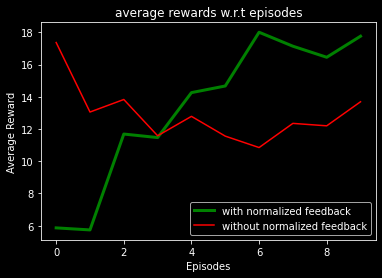

In [ ]:
from matplotlib import pyplot as plt
plt.plot(norm_feedback_avg_rewards,'g',linewidth=3)
plt.plot(with_feedback_avg_rewards,'r',linewidth=1.5)
plt.plot()
plt.legend(["with normalized feedback", "without normalized feedback"], loc ="lower right")
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('average rewards w.r.t episodes')
plt.style.use('dark_background')
plt.show()

# ***Plotting Average Rewards vs Episodes for "without feedback" vs "with feedback" vs with "normalized feedback"***

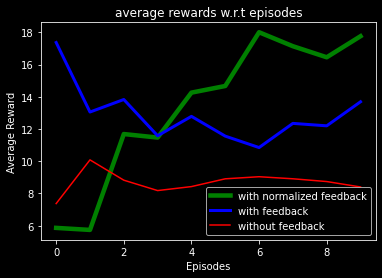

In [ ]:
from matplotlib import pyplot as plt
plt.plot(norm_feedback_avg_rewards,'g',linewidth=4.5)
plt.plot(with_feedback_avg_rewards,'b',linewidth=3)
plt.plot(without_feedback_avg_rewards,'r',linewidth=1.5)
plt.plot()
plt.legend(["with normalized feedback", "with feedback", "without feedback"], loc ="lower right")
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('average rewards w.r.t episodes')
plt.style.use('dark_background')
plt.show()